# Importamos librerias a usar

In [86]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score

# Cargamos y dividimos nuestra data prepocesada

In [87]:
df= pd.read_csv('../data/process/data.csv')

In [88]:
X = df.drop(columns=['Fraud'])
y = df['Fraud']

In [89]:
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_ratio/(train_ratio+test_ratio), random_state=42, stratify=y_train)

In [91]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(7000, 8)
(1500, 8)
(1500, 8)


# Construimos modelo MLP del tipo AutoEncoder

In [92]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int):
        assert input_dim > 0, "Input dimension must be greater than 0"
        assert hidden_dim > 0, "Hidden dimension must be greater than 0"

        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

        self.out = nn.Sigmoid()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.out(x)
        return x


In [93]:
features_names = ["Amount", "MCC_5261","MCC_5411","MCC_5812","MCC_5942","MCC_5968","MCC_7299", "TransactionSpeed"]

In [94]:
def train_ae_model(data: pd.DataFrame, num_epochs=100, batch_size=32, hidden_dim=64):
    features = data.loc[:, features_names]
    model = AutoEncoder(input_dim=len(features_names), hidden_dim=hidden_dim)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    dataset = torch.utils.data.TensorDataset(torch.tensor(features.values, dtype=torch.float32))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            outputs = model(batch[0])
            loss = criterion(outputs, batch[0])
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    return model

# Entrenamiento

In [95]:
normal_data = df[df['Fraud'] == 0]
ae_model = train_ae_model(normal_data)


Epoch [1/100], Loss: 0.1682
Epoch [2/100], Loss: 0.1628
Epoch [3/100], Loss: 0.1130
Epoch [4/100], Loss: 0.1552
Epoch [5/100], Loss: 0.0835
Epoch [6/100], Loss: 0.1055
Epoch [7/100], Loss: 0.1753
Epoch [8/100], Loss: 0.1593
Epoch [9/100], Loss: 0.0915
Epoch [10/100], Loss: 0.0544
Epoch [11/100], Loss: 0.1360
Epoch [12/100], Loss: 0.1052
Epoch [13/100], Loss: 0.2143
Epoch [14/100], Loss: 0.1367
Epoch [15/100], Loss: 0.0621
Epoch [16/100], Loss: 0.1664
Epoch [17/100], Loss: 0.0790
Epoch [18/100], Loss: 0.2490
Epoch [19/100], Loss: 0.2296
Epoch [20/100], Loss: 0.1679
Epoch [21/100], Loss: 0.1648
Epoch [22/100], Loss: 0.3241
Epoch [23/100], Loss: 0.1603
Epoch [24/100], Loss: 0.1086
Epoch [25/100], Loss: 0.0719
Epoch [26/100], Loss: 0.1010
Epoch [27/100], Loss: 0.1703
Epoch [28/100], Loss: 0.0937
Epoch [29/100], Loss: 0.0878
Epoch [30/100], Loss: 0.0643
Epoch [31/100], Loss: 0.1197
Epoch [32/100], Loss: 0.1155
Epoch [33/100], Loss: 0.1559
Epoch [34/100], Loss: 0.1086
Epoch [35/100], Loss: 0

In [109]:
print(ae_model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
  (out): Sigmoid()
)


# Evaluacion del modelo

In [96]:
def get_reconstruction_errors(model, data_tensor):
    model.eval()
    with torch.no_grad():
        reconstructed = model(data_tensor)
        errors = torch.mean((reconstructed - data_tensor) ** 2, dim=1)
    return errors.numpy()

In [97]:
def evaluate_results(y_true, y_pred, errors, dataset_name="Validación"):
    print(f"\n=== {dataset_name.upper()} ===")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("ROC AUC :", roc_auc_score(y_true, errors))
    print("Matriz de Confusión:")
    print(confusion_matrix(y_true, y_pred))

In [98]:
X_train_tensor = torch.tensor(X_train[features_names].values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid[features_names].values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test[features_names].values,  dtype=torch.float32)

errors_train = get_reconstruction_errors(ae_model, X_train_tensor)
errors_valid = get_reconstruction_errors(ae_model, X_valid_tensor)
errors_test  = get_reconstruction_errors(ae_model, X_test_tensor)

In [99]:
threshold = np.quantile(errors_valid, 0.75)

y_train_pred = (errors_train > threshold).astype(int)
y_valid_pred = (errors_valid > threshold).astype(int)
y_test_pred  = (errors_test > threshold).astype(int)

In [102]:
evaluate_results(y_valid, y_valid_pred, errors_valid, "VALIDACION")
evaluate_results(y_test,  y_test_pred,  errors_test,  "TEST")


=== VALIDACION ===
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1471
           1       0.07      0.90      0.13        29

    accuracy                           0.77      1500
   macro avg       0.53      0.83      0.50      1500
weighted avg       0.98      0.77      0.85      1500

ROC AUC : 0.9217750064464708
Matriz de Confusión:
[[1122  349]
 [   3   26]]

=== TEST ===
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1471
           1       0.07      0.86      0.12        29

    accuracy                           0.76      1500
   macro avg       0.53      0.81      0.49      1500
weighted avg       0.98      0.76      0.85      1500

ROC AUC : 0.9274947842190393
Matriz de Confusión:
[[1122  349]
 [   4   25]]


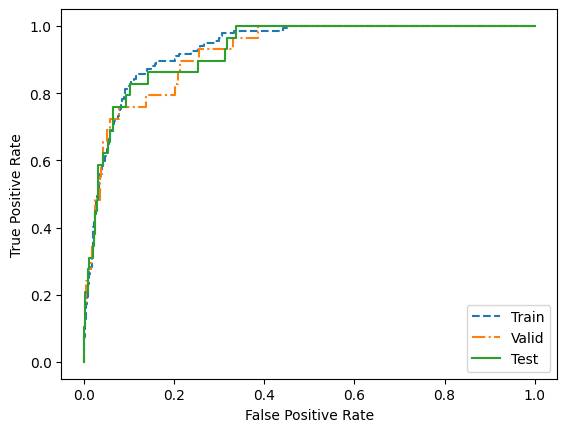

In [103]:
fpr_train, tpr_train, _ = roc_curve(y_train, errors_train)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, errors_valid)
fpr_test,  tpr_test,  _ = roc_curve(y_test,  errors_test)

plt.plot(fpr_train, tpr_train, linestyle='--', label='Train')
plt.plot(fpr_valid, tpr_valid, linestyle='-.', label='Valid')
plt.plot(fpr_test,  tpr_test,  linestyle='-',  label='Test')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()